In [19]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from transformers import AdamW, get_scheduler

from jre_utils.datapath import (
    processed_pretraining_data_paths,
    pretraining_data_paths,
    pretrained_weights_paths,
)
from jre_utils.data import TimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.engine import (
    evaluate,
    train,
    EarlyStopper,
)
from jre_utils.metrics import MSELossWeighted

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [20]:
datasets = ["ettm1", "ettm2", "etth1", "etth2"]
dataset = "ettm2"
df = pd.read_csv(pretraining_data_paths[dataset])
date_time = pd.to_datetime(df.pop("date"), format='%Y/%m/%d %H:%M')

In [21]:
df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000
2,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002
3,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001
4,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
...,...,...,...,...,...,...,...
69675,42.722000,12.230,54.014000,12.652,-11.525,-1.418,45.986500
69676,38.868000,10.052,49.859001,10.669,-11.525,-1.418,45.986500
69677,39.622002,11.057,50.448002,11.795,-10.299,-1.418,45.546501
69678,40.459999,11.392,51.841999,11.929,-11.536,-1.418,45.546501


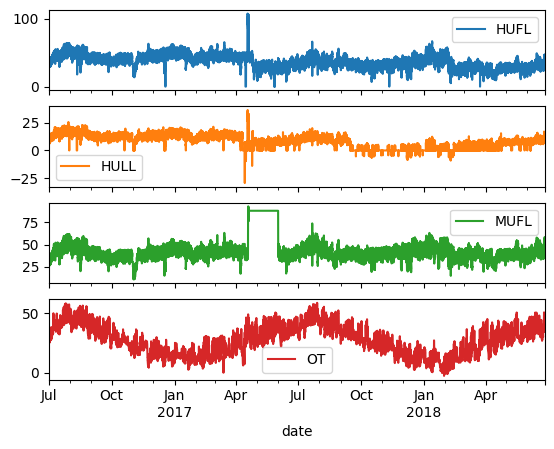

In [22]:
plot_cols = ['HUFL', 'HULL', 'MUFL', 'OT']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


In [23]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
HUFL,69680.0,37.219411,10.243442,0.0000,30.156000,37.277000,44.146000,107.892998
HULL,69680.0,8.554209,6.031270,-29.3190,4.523000,9.131000,13.235000,36.438999
MUFL,69680.0,43.861438,13.061909,10.4270,37.421001,41.415001,46.186001,93.230003
MULL,69680.0,8.340187,4.369039,-6.6480,5.656000,9.328000,11.285000,29.808001
LUFL,69680.0,-3.430701,6.154438,-14.6170,-9.286000,-3.774000,2.527000,17.218000
LULL,69680.0,-2.084888,6.013584,-31.4620,-2.505000,-1.226000,0.000000,3.731000
OT,69680.0,26.609799,11.886536,-2.6465,16.469500,26.577000,35.585999,58.876999


In [24]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.9)]
val_df = df[int(n*0.9):]

num_features = df.shape[1]

In [25]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std

In [26]:
train_df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,0.292261,0.613372,-0.569050,0.245910,1.187957,0.539172,1.059677
1,0.145110,0.427543,-0.642024,0.069326,0.982196,0.530804,1.023397
2,0.071534,0.307991,-0.728753,-0.142619,1.189820,0.530804,0.950754
3,-0.255361,0.095366,-0.860871,0.104687,1.189820,0.524016,0.932573
4,-0.059224,0.241555,-0.760311,-0.154479,1.189820,0.524016,0.932573
...,...,...,...,...,...,...,...
62707,-1.963800,-1.365581,-1.259209,-0.790313,-1.238502,0.067899,-0.758215
62708,-2.315285,-1.365581,-1.359768,-0.860815,-1.451546,0.067899,-0.776396
62709,-2.217216,-1.365581,-1.387354,-0.878606,-1.242228,0.067899,-0.794536
62710,-2.413353,-1.365581,-1.533301,-1.072760,-1.242228,0.067899,-0.812676


In [27]:
train_df.to_csv(processed_pretraining_data_paths[dataset]["train"], index=False)
val_df.to_csv(processed_pretraining_data_paths[dataset]["eval"], index=False)

In [28]:
# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

In [29]:
BATCH_SIZE = 64
window_length = 10
shift = 1

feature_columns = df.columns
metrics = ["OT"]

train_dataset = TimeSeriesDataset(
    train_df,
    metrics=metrics,
    feature_columns=feature_columns,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)
val_dataset = TimeSeriesDataset(
    val_df,
    metrics=metrics,
    feature_columns=feature_columns,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)

In [30]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
eval_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [31]:
for i, sample in enumerate(train_dataloader):
    if i == 0:
        print(i, sample["window"].shape, sample["target"].shape)
        break

0 torch.Size([64, 10, 7]) torch.Size([64, 1])


In [32]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [33]:
n_features = len(feature_columns)
target_size = len(metrics)
d_model = 128
d_hid = 256
nlayers = 4
nhead = 4
dropout = 0.1
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    target_size=target_size,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    device=device,
)
model = model.to(device)


In [35]:
n_features

7

In [34]:
model.eval()
mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        print("Loss:", loss.item())

        if i == 0:
            break

torch.Size([64, 10, 7]) torch.Size([64, 10]) torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1])
Loss: 0.17294225096702576


In [40]:
learning_rate = 1e-4
num_epochs = 20

In [41]:
train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [42]:
num_training_steps = num_epochs * len(train_dataloader)

optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

for epoch in range(num_epochs):
    train_loss, train_r2_score = train(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

    if early_stopper.early_stop(eval_loss):
        print(f"Early stopping at epoch {epoch}")
        break


progress_bar.close()

100%|██████████| 4900/4900 [07:14<00:00, 11.28it/s]


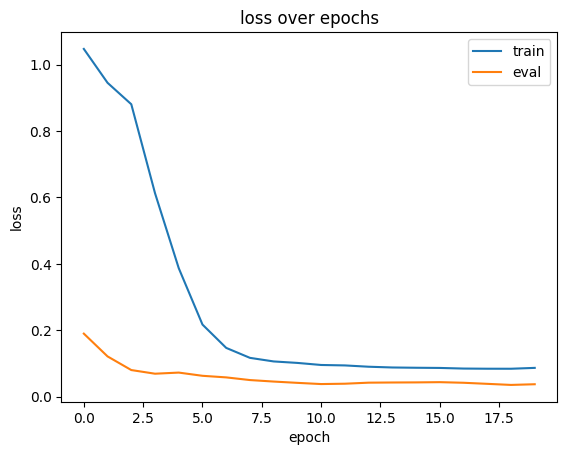

In [43]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

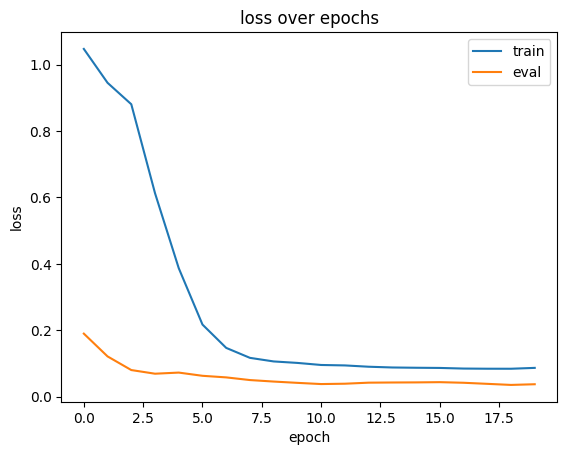

In [44]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

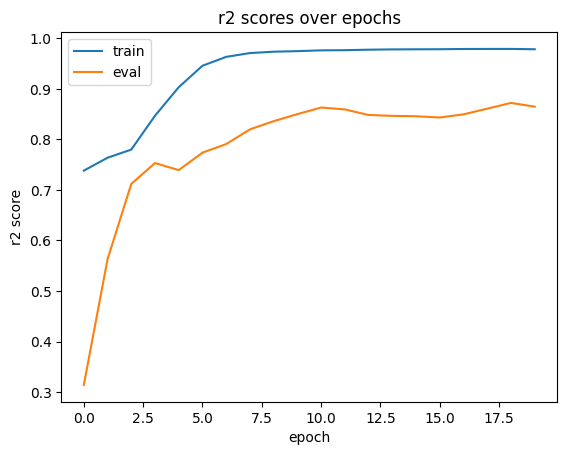

In [45]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()